# Preprocessing & Filtering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load our new, safe, and small dataset
df = pd.read_csv('complaints_lite.csv')

# See what we're working with
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116584 entries, 0 to 116583
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 116584 non-null  object
 1   Product                       116584 non-null  object
 2   Sub-product                   114212 non-null  object
 3   Issue                         116584 non-null  object
 4   Sub-issue                     107715 non-null  object
 5   Consumer complaint narrative  34454 non-null   object
 6   Company public response       58949 non-null   object
 7   Company                       116584 non-null  object
 8   State                         116008 non-null  object
 9   ZIP code                      116286 non-null  object
 10  Tags                          6762 non-null    object
 11  Consumer consent provided?    97326 non-null   object
 12  Submitted via                 116584 non-null  object
 13 

In [2]:
# Rename our chosen columns to the simple names we'll use in the project
df = df.rename(columns={
    'Consumer complaint narrative': 'text',
    'Product': 'category'
})

# --- CRITICAL STEP ---
# Drop all rows where the complaint text ('text') is missing (NaN)
df = df.dropna(subset=['text', 'category'])

# Keep only the two columns we will use
df = df[['text', 'category']]

print(f"\nSuccessfully filtered columns. We now have {len(df)} complaints to work with.")
print(df.head())


Successfully filtered columns. We now have 34454 complaints to work with.
                                                 text  \
15  On XX/XX/XXXX I mailed notices to all CRAs to ...   
29  I am a victim of identity theft in which my pu...   
43  I sent a letter off on XX/XX/2022. To remove p...   
50  This CFPB complaint has been filed to request ...   
59  XXXX XXXX XXXX XXXX XXXX XXXX. \nXXXXXXXX XXXX...   

                                             category  
15  Credit reporting or other personal consumer re...  
29  Credit reporting or other personal consumer re...  
43  Credit reporting, credit repair services, or o...  
50  Credit reporting or other personal consumer re...  
59  Credit reporting or other personal consumer re...  



--- Category Counts (Original) ---
category
Credit reporting or other personal consumer reports                             14460
Credit reporting, credit repair services, or other personal consumer reports     8093
Debt collection                                                                  3830
Checking or savings account                                                      1530
Mortgage                                                                         1446
Credit card or prepaid card                                                      1074
Money transfer, virtual currency, or money service                               1053
Credit card                                                                       927
Student loan                                                                      562
Vehicle loan or lease                                                             422
Credit reporting                                                                  326
Payday lo

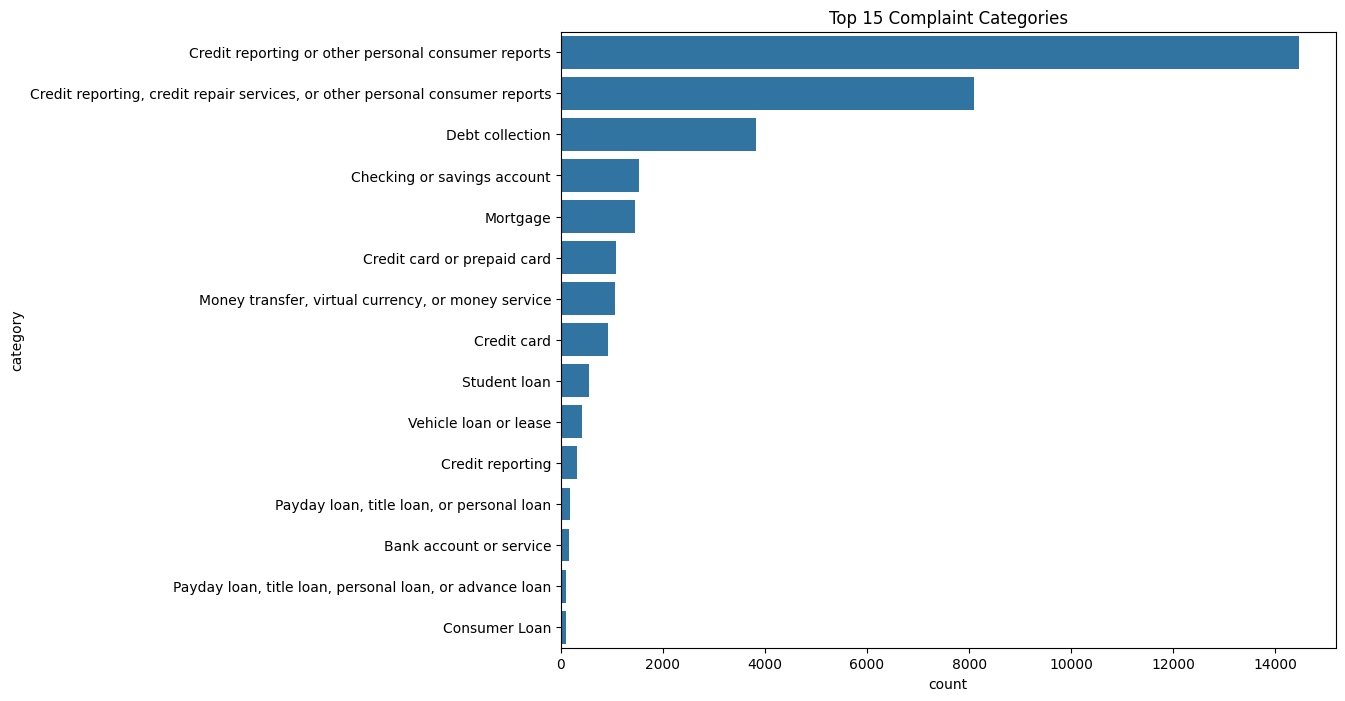


Original count: 34454, Filtered count: 29359

--- Final Category Distribution ---
category
Credit reporting or other personal consumer reports                             14460
Credit reporting, credit repair services, or other personal consumer reports     8093
Debt collection                                                                  3830
Checking or savings account                                                      1530
Mortgage                                                                         1446
Name: count, dtype: int64


In [3]:
# See how many complaints are in each category
print("\n--- Category Counts (Original) ---")
print(df['category'].value_counts())

# Plot it to see the distribution
plt.figure(figsize=(10, 8))
# Use '...value_counts().nlargest(15).index' to only show the top 15 in the plot
sns.countplot(y='category', data=df, order=df['category'].value_counts().nlargest(15).index)
plt.title('Top 15 Complaint Categories')
plt.show()

# --- IMPORTANT FILTERING STEP ---

# Get the names of the top 5 most common categories
# You can change nlargest(5) to nlargest(7) or nlargest(10) if you want more classes
top_categories = df['category'].value_counts().nlargest(5).index

# Filter the DataFrame to only keep rows with these top 5 categories
df_final = df[df['category'].isin(top_categories)]

print(f"\nOriginal count: {len(df)}, Filtered count: {len(df_final)}")
print("\n--- Final Category Distribution ---")
print(df_final['category'].value_counts())

Merging redundant categories...

--- Final, CLEANED Category Distribution ---
category
Credit Reporting               22553
Debt collection                 3830
Checking or savings account     1530
Mortgage                        1446
Name: count, dtype: int64


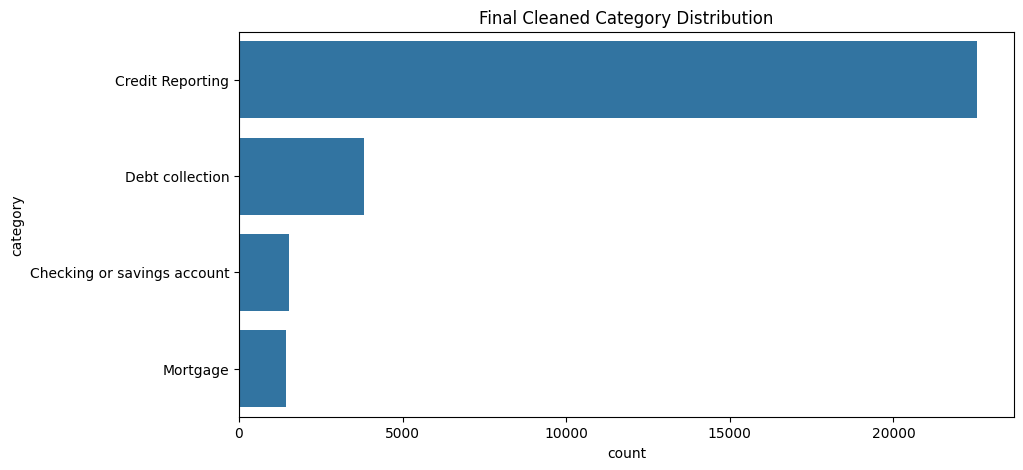


--- 🥳 Phase 0 Complete! ---
Saved 'complaints_final_clean.csv' with 4 clean, distinct categories.
This is the file we will use for all model training.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the "Lite" Dataset ---
df = pd.read_csv('complaints_lite.csv')

# --- 2. Rename and Clean Columns ---
df = df.rename(columns={
    'Consumer complaint narrative': 'text',
    'Product': 'category'
})
df = df.dropna(subset=['text', 'category'])
df = df[['text', 'category']]

# --- 3. MERGE Redundant Categories ---
print("Merging redundant categories...")

# This map will combine the two "Credit reporting" labels into one
merge_map = {
    'Credit reporting or other personal consumer reports': 'Credit Reporting',
    'Credit reporting, credit repair services, or other personal consumer reports': 'Credit Reporting'
}

# Apply the merge
df['category'] = df['category'].replace(merge_map)


# --- 4. Define Our Final, DISTINCT Categories ---
# Now we have 4 clean, distinct categories from your "Top 5" list
final_categories = [
    'Credit Reporting',
    'Debt collection',
    'Checking or savings account',
    'Mortgage'
]

# Filter the DataFrame to *only* keep rows with these 4 categories
df_final = df[df['category'].isin(final_categories)]


# --- 5. Verify and Save the FINAL Dataset ---
print("\n--- Final, CLEANED Category Distribution ---")
print(df_final['category'].value_counts())

# Plot the new, clean distribution
plt.figure(figsize=(10, 5))
sns.countplot(y='category', data=df_final, order=df_final['category'].value_counts().index)
plt.title('Final Cleaned Category Distribution')
plt.show()

# Save our final, clean, filtered, and perfectly-sized dataset
df_final.to_csv('complaints_final_clean.csv', index=False)

print("\n--- 🥳 Phase 0 Complete! ---")
print("Saved 'complaints_final_clean.csv' with 4 clean, distinct categories.")
print("This is the file we will use for all model training.")

# Model 1: TF-IDF + Naive Bayes

In [1]:
import pandas as pd
import nltk
import string
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Download the NLTK stopwords list
# This only needs to be run once
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Create a set of stopwords for fast lookup
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Applies all preprocessing steps to a single string of text.
    1. Lowercase
    2. Remove Punctuation
    3. Remove Stopwords
    """
    
    # 1. Lowercase the text
    text = text.lower()
    
    # 2. Remove punctuation
    # Create a translation table that maps each punctuation char to None
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    # 3. Remove stopwords
    # Split text into words, filter out stopwords, and join back into a string
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

# Let's test it on an example
example_text = "Hello! This is a test sentence, showing how it works."
print(f"Original: {example_text}")
print(f"Cleaned:  {clean_text(example_text)}")

Original: Hello! This is a test sentence, showing how it works.
Cleaned:  hello test sentence showing works


In [3]:
# Load the dataset
df = pd.read_csv('complaints_final_clean.csv')

# Define our features (X) and target (y)
X = df['text']
y = df['category']

# Create the train/test split
# We use a 75/25 split and set random_state for reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape:  {X_test.shape}")

Training data shape: (22019,)
Testing data shape:  (7340,)


In [4]:
# --- Define the Model 1 Pipeline ---
model_1 = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=clean_text)),
    ('nb', MultinomialNB())
])

# --- Train the Model ---
print("\nTraining Model 1 (TF-IDF + Naive Bayes)...")
model_1.fit(X_train, y_train)
print("Training complete.")

# --- Save the Model to Disk ---
model_filename = 'model_1_nb.pkl'
joblib.dump(model_1, model_filename)

print(f"✅ Model 1 successfully trained and saved to '{model_filename}'")


Training Model 1 (TF-IDF + Naive Bayes)...
Training complete.
✅ Model 1 successfully trained and saved to 'model_1_nb.pkl'


In [5]:
# Get predictions on the test set
y_pred_1 = model_1.predict(X_test)

# Print a detailed classification report
print("\n--- Model 1 Performance (on Test Set) ---")
print(classification_report(y_test, y_pred_1))


--- Model 1 Performance (on Test Set) ---
                             precision    recall  f1-score   support

Checking or savings account       0.99      0.30      0.46       383
           Credit Reporting       0.81      1.00      0.90      5638
            Debt collection       0.82      0.17      0.28       958
                   Mortgage       0.95      0.27      0.42       361

                   accuracy                           0.82      7340
                  macro avg       0.89      0.43      0.51      7340
               weighted avg       0.83      0.82      0.77      7340



# Model 2: TF-IDF + Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
import joblib

# Note: We are re-using X_train, X_test, y_train, y_test, and the 
# clean_text function from the previous step. No need to reload.

In [7]:
# --- Define the Model 2 Pipeline ---
model_2 = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=clean_text)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42)) 
    # We add max_iter to prevent convergence warnings
])

# --- Train the Model ---
print("\nTraining Model 2 (TF-IDF + Logistic Regression)...")
model_2.fit(X_train, y_train)
print("Training complete.")

# --- Save the Model to Disk ---
model_filename = 'model_2_lr.pkl'
joblib.dump(model_2, model_filename)

print(f"✅ Model 2 successfully trained and saved to '{model_filename}'")


Training Model 2 (TF-IDF + Logistic Regression)...
Training complete.
✅ Model 2 successfully trained and saved to 'model_2_lr.pkl'


In [8]:
# Get predictions on the test set
y_pred_2 = model_2.predict(X_test)

# Print a detailed classification report
print("\n--- Model 2 Performance (on Test Set) ---")
print(classification_report(y_test, y_pred_2))


--- Model 2 Performance (on Test Set) ---
                             precision    recall  f1-score   support

Checking or savings account       0.93      0.90      0.91       383
           Credit Reporting       0.93      0.97      0.95      5638
            Debt collection       0.83      0.65      0.73       958
                   Mortgage       0.93      0.85      0.89       361

                   accuracy                           0.92      7340
                  macro avg       0.90      0.85      0.87      7340
               weighted avg       0.92      0.92      0.92      7340



# Model 3: Word2Vec + Logistic Regression

In [11]:
import gensim
import numpy as np
from sklearn.linear_model import LogisticRegression
import joblib

# We are re-using X_train, X_test, y_train, y_test, and the 
# clean_text function from the previous steps.

In [12]:
# Apply the clean_text function and then split each complaint into a list of words
print("Preparing data for Word2Vec...")
X_train_tokens = [clean_text(complaint).split() for complaint in X_train]
X_test_tokens = [clean_text(complaint).split() for complaint in X_test]

print(f"Example of tokenized data: {X_train_tokens[0]}")

Preparing data for Word2Vec...
Example of tokenized data: ['affected', 'equifax', 'data', 'breach', 'per', '15', 'usc', '1681', 'c2', 'states', 'except', 'otherwise', 'provided', 'section', 'consumer', 'reporting', 'agency', 'shall', 'block', 'reporting', 'information', 'file', 'consumer', 'consumer', 'identifies', 'information', 'resulted', 'alleged', 'identity', 'theft', 'account', 'name', 'xxxx', 'xxxx', 'xxxxxxxx', 'account', 'name', 'xxxxxxxx', 'xxxx', 'xxxx', 'xxxx', 'account', 'name', 'xxxx', 'xxxx', 'xxxx', 'account', 'name', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'account', 'name', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'account', 'name', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxxxxxx', 'account', 'name', 'xxxx', 'xxxx', 'xxxx']


In [13]:
# --- Train the Word2Vec Model ---
print("\nTraining Word2Vec model...")
# vector_size=100: Each word will be a 100-dimension vector
# window=5:      Looks at 5 words before and 5 words after
# min_count=2:   Ignores words that appear less than 2 times
w2v_model = gensim.models.Word2Vec(X_train_tokens,
                                   vector_size=100,
                                   window=5,
                                   min_count=2,
                                   workers=4)
print("Word2Vec training complete.")

# --- Save the Word2Vec Model ---
w2v_filename = 'model_3_w2v.model'
w2v_model.save(w2v_filename)
print(f"Word2Vec model saved to '{w2v_filename}'")


Training Word2Vec model...
Word2Vec training complete.
Word2Vec model saved to 'model_3_w2v.model'


In [14]:
def vectorize_complaints(complaints_tokens_list, model):
    """Averages the word vectors for all words in a single complaint."""
    vectors = []
    for tokens in complaints_tokens_list:
        # Get vectors for words that are in the model's vocabulary
        word_vectors = [model.wv[word] for word in tokens if word in model.wv]
        
        if len(word_vectors) > 0:
            # If we have vectors, average them
            avg_vector = np.mean(word_vectors, axis=0)
            vectors.append(avg_vector)
        else:
            # If no words are in vocab (e.g., "Xxxx Xxxxx"), create a zero vector
            vectors.append(np.zeros(model.vector_size))
            
    return np.array(vectors)

# --- Create our new training and testing data ---
print("\nVectorizing complaints using Word2Vec model...")
X_train_vecs = vectorize_complaints(X_train_tokens, w2v_model)
X_test_vecs = vectorize_complaints(X_test_tokens, w2v_model)

print(f"New training data shape: {X_train_vecs.shape}")
print(f"New testing data shape:  {X_test_vecs.shape}")


Vectorizing complaints using Word2Vec model...
New training data shape: (22019, 100)
New testing data shape:  (7340, 100)


In [15]:
# --- Define and Train Model 3 ---
print("\nTraining Model 3 (Logistic Regression on W2V vectors)...")
# Note: We are training this *only* on the new vector data
model_3 = LogisticRegression(max_iter=1000, random_state=42)
model_3.fit(X_train_vecs, y_train)
print("Training complete.")

# --- Save the Model to Disk ---
model_filename = 'model_3_lr.pkl'
joblib.dump(model_3, model_filename)

print(f"✅ Model 3 successfully trained and saved to '{model_filename}'")


Training Model 3 (Logistic Regression on W2V vectors)...
Training complete.
✅ Model 3 successfully trained and saved to 'model_3_lr.pkl'


In [16]:
# Get predictions on the test set
y_pred_3 = model_3.predict(X_test_vecs)

# Print a detailed classification report
print("\n--- Model 3 Performance (on Test Set) ---")
print(classification_report(y_test, y_pred_3))


--- Model 3 Performance (on Test Set) ---
                             precision    recall  f1-score   support

Checking or savings account       0.86      0.91      0.89       383
           Credit Reporting       0.93      0.96      0.94      5638
            Debt collection       0.76      0.56      0.64       958
                   Mortgage       0.87      0.87      0.87       361

                   accuracy                           0.90      7340
                  macro avg       0.85      0.83      0.84      7340
               weighted avg       0.90      0.90      0.90      7340



# Model 4: LSTM (with Keras)

In [17]:
import pandas as pd
import numpy as np
import joblib
import gensim
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# We will need to re-load our clean data
df = pd.read_csv('complaints_final_clean.csv')

# --- We will use our *cleaned* text for this ---
# (We can re-use the `clean_text` function from Model 1)
print("Cleaning text for LSTM...")
df['cleaned_text'] = df['text'].apply(clean_text)

Cleaning text for LSTM...


In [18]:
# --- 1. Create Numerical Labels ---
le = LabelEncoder()
df['label'] = le.fit_transform(df['category'])

# Save the label encoder for our app
joblib.dump(le, 'model_4_label_encoder.pkl')
print(f"Label encoder saved. Classes: {le.classes_}")

# --- 2. Tokenize and Pad Sequences ---
# We'll use the top 10,000 most common words
MAX_NUM_WORDS = 10000
# We'll pad/truncate every complaint to be 150 words long
MAX_SEQ_LENGTH = 150

# Create the Keras tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df['cleaned_text'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Pad the sequences
X = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH)
y = df['label'].values

# Get the word-to-index mapping from our tokenizer
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

# Save the tokenizer for our app
joblib.dump(tokenizer, 'model_4_keras_tokenizer.pkl')

# --- 3. Split the Data ---
# We MUST use the same random_state=42 to keep the test set consistent!
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Padded sequence data (X_train_seq) shape: {X_train_seq.shape}")
print(f"Labels (y_train_seq) shape: {y_train_seq.shape}")

Label encoder saved. Classes: ['Checking or savings account' 'Credit Reporting' 'Debt collection'
 'Mortgage']
Found 28461 unique tokens.
Padded sequence data (X_train_seq) shape: (22019, 150)
Labels (y_train_seq) shape: (22019,)


In [19]:
# Load our pre-trained Word2Vec model
w2v_model = gensim.models.Word2Vec.load('model_3_w2v.model')

# Get the vector size (should be 100)
EMBEDDING_DIM = w2v_model.vector_size

# Create a matrix of zeros
# We add 1 because word_index starts at 1 (0 is reserved for padding)
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

# Fill the matrix with our Word2Vec vectors
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

print("Embedding matrix created.")

Embedding matrix created.


In [20]:
# --- 1. Define the Model Architecture ---
model_4 = Sequential()

# The Embedding layer (Layer 1)
# This is the "dictionary" for our model.
# We set `trainable=False` to *freeze* our Word2Vec weights.
model_4.add(Embedding(input_dim=num_words,
                      output_dim=EMBEDDING_DIM,
                      weights=[embedding_matrix],
                      input_length=MAX_SEQ_LENGTH,
                      trainable=False))

# The LSTM layer (Layer 2)
# This is the "brain" that reads the sequence.
model_4.add(LSTM(64, dropout=0.2)) # 64 is the number of memory units

# The Output layer (Layer 3)
# A standard "Dense" layer to make the final classification.
# The activation is 'softmax' because this is a multi-class problem.
num_classes = len(le.classes_)
model_4.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_4.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

print(model_4.summary())

# --- 2. Train the Model ---
print("\nTraining Model 4 (LSTM)...")
# We'll use 5 epochs and use 10% of our training data for validation
history = model_4.fit(X_train_seq, y_train_seq,
                      epochs=5,
                      batch_size=64,
                      validation_split=0.1,
                      verbose=1)

print("Training complete.")

# --- 3. Save the Model ---
model_filename = 'model_4_lstm.h5'
model_4.save(model_filename)
print(f"✅ Model 4 successfully trained and saved to '{model_filename}'")

c:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

None

Training Model 4 (LSTM)...
Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.7794 - loss: 0.6126 - val_accuracy: 0.9010 - val_loss: 0.2947
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8929 - loss: 0.3032 - val_accuracy: 0.9087 - val_loss: 0.2568
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9009 - loss: 0.2805 - val_accuracy: 0.9137 - val_loss: 0.2407
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9121 - loss: 0.2451 - val_accuracy: 0.9187 - val_loss: 0.2291
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9208 - loss: 0.2303 - val_accuracy: 0.9242 - val_loss: 0.2181


Training complete.
✅ Model 4 successfully trained and saved to 'model_4_lstm.h5'


In [21]:
# --- Evaluate the Model ---
print("\n--- Model 4 Performance (on Test Set) ---")
y_pred_probs = model_4.predict(X_test_seq)
y_pred_4 = np.argmax(y_pred_probs, axis=1) # Get the class with the highest probability

# Use the label encoder to get the *names* of the classes
target_names = le.classes_
print(classification_report(y_test_seq, y_pred_4, target_names=target_names))


--- Model 4 Performance (on Test Set) ---
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
                             precision    recall  f1-score   support

Checking or savings account       0.86      0.93      0.89       383
           Credit Reporting       0.95      0.96      0.96      5638
            Debt collection       0.78      0.70      0.74       958
                   Mortgage       0.91      0.87      0.89       361

                   accuracy                           0.92      7340
                  macro avg       0.87      0.87      0.87      7340
               weighted avg       0.92      0.92      0.92      7340



# Model 5: Fine-Tuned DistilBERT (Transformer)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate # Hugging Face's evaluation library

# We will need to re-load our clean data
df = pd.read_csv('complaints_final_clean.csv')

# --- IMPORTANT: Create a mapping from category name (string) to ID (int) ---
# Transformers models need numerical labels for classification
labels = df['category'].unique()
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

# Add a new 'label' column to our DataFrame with the integer IDs
df['label'] = df['category'].map(label2id)

print("Label to ID mapping created:")
print(label2id)

Label to ID mapping created:
{'Credit Reporting': 0, 'Checking or savings account': 1, 'Debt collection': 2, 'Mortgage': 3}


In [4]:
# First, split using sklearn to ensure the exact same split
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42, stratify=df['category'])

# Convert the pandas DataFrames into Hugging Face's `Dataset` format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Combine them into a DatasetDict (the format the Trainer expects)
ds = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

print("\nDataset structure:")
print(ds)


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'category', 'label', '__index_level_0__'],
        num_rows: 22019
    })
    test: Dataset({
        features: ['text', 'category', 'label', '__index_level_0__'],
        num_rows: 7340
    })
})


In [5]:
# Load the tokenizer for DistilBERT
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Create a function to tokenize our text
def preprocess_function(examples):
    # The tokenizer will handle the text. `truncation=True` cuts off
    # complaints that are too long. `padding=True` is also good.
    return tokenizer(examples['text'], truncation=True, padding=True)

# Apply the tokenization to our entire dataset in batches
tokenized_ds = ds.map(preprocess_function, batched=True)

print("\nTokenized dataset structure:")
print(tokenized_ds)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/22019 [00:00<?, ? examples/s]

Map:   0%|          | 0/7340 [00:00<?, ? examples/s]


Tokenized dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'category', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 22019
    })
    test: Dataset({
        features: ['text', 'category', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 7340
    })
})


In [6]:
# Load the pre-trained DistilBERT model
# We tell it the number of labels and our new id2label mapping
model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', 
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# Load the "accuracy" metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    """Calculates accuracy during evaluation."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Define the Training Arguments
training_args = TrainingArguments(
    output_dir="model_5_distilbert_checkpoints", # Where to save checkpoints
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3, # 3 epochs is a good starting point
    weight_decay=0.01,
    evaluation_strategy="epoch", # Evaluate at the end of each epoch
    save_strategy="epoch",       # Save at the end of each epoch
    load_best_model_at_end=True, # Will load the best model (by loss)
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_6172\1113478212.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [8]:
import torch

# Check if CUDA (GPU) is available
is_cuda_available = torch.cuda.is_available()

if is_cuda_available:
    print("--- 🥳 SUCCESS! ---")
    print(f"CUDA is available. PyTorch can see your GPU.")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
else:
    print("--- ⚠️ WARNING ---")
    print("CUDA is NOT available. PyTorch cannot see your GPU.")
    print("Training will run on the CPU (which will be very slow).")
    print("Make sure you have PyTorch with CUDA support installed in this environment.")

--- 🥳 SUCCESS! ---
CUDA is available. PyTorch can see your GPU.
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [9]:
# --- Train the Model (This will now use your GPU) ---
print("\nTraining Model 5 (DistilBERT) on GPU...")
print("This will be much faster now. 🚀")
trainer.train()
print("Training complete.")

# --- Save the Final Model ---
model_directory = "model_5_distilbert_final"
trainer.save_model(model_directory)
tokenizer.save_pretrained(model_directory) # Save the tokenizer with the model
print(f"✅ Model 5 successfully trained and saved to '{model_directory}'")



Training Model 5 (DistilBERT) on GPU...
This will be much faster now. 🚀


Epoch,Training Loss,Validation Loss,Accuracy
1,0.235700,0.224421,0.927520
2,0.165400,0.226838,0.932425
3,0.121400,0.245548,0.933787


Training complete.
✅ Model 5 successfully trained and saved to 'model_5_distilbert_final'


In [11]:
from sklearn.metrics import classification_report

# Run the final evaluation
eval_results = trainer.evaluate()

print("\n--- Model 5 Performance (on Test Set) ---")
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Loss: {eval_results['eval_loss']:.4f}")

# To get the full classification report, we'll do one extra step
print("\n--- Full Classification Report ---")
predictions = trainer.predict(tokenized_ds["test"])
y_pred_5 = np.argmax(predictions.predictions, axis=-1)
y_test_labels = tokenized_ds["test"]["label"]

# We need the *names* of the labels, not the IDs
target_names = [id2label[i] for i in range(len(labels))]
print(classification_report(y_test_labels, y_pred_5, target_names=target_names))


--- Model 5 Performance (on Test Set) ---
Accuracy: 0.9275
Loss: 0.2244

--- Full Classification Report ---
                             precision    recall  f1-score   support

           Credit Reporting       0.95      0.97      0.96      5638
Checking or savings account       0.85      0.97      0.91       383
            Debt collection       0.83      0.66      0.74       958
                   Mortgage       0.93      0.88      0.90       361

                   accuracy                           0.93      7340
                  macro avg       0.89      0.87      0.88      7340
               weighted avg       0.93      0.93      0.92      7340

